# Using dirichlet processes and mixture modelling to find groups

## Imports

In [1]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import scale
import seaborn as sns

## Simulation settings

In [2]:
n = 40
group_1_beta_mean = 0.2
group_2_beta_mean = 0.8
sd = 0.05
epsilon = 1

## Distributions of $\beta$ values

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\scipy\stats\stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


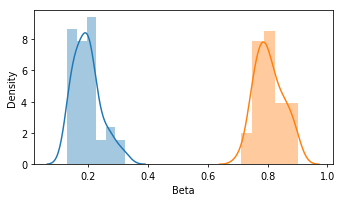

In [3]:
plt.figure(figsize=(5, 3), dpi=70)
group_1_betas = np.random.normal(group_1_beta_mean, sd, n)
group_2_betas = np.random.normal(group_2_beta_mean, sd, n)
sns.distplot(group_1_betas)
sns.distplot(group_2_betas);
plt.xlabel("Beta")
plt.ylabel("Density")
plt.tight_layout()
plt.savefig("true_betas.png");

## Create data

Data generated according to a simple linear model with no intercept 

$y = \beta x + \epsilon$

In [4]:
x = np.tile(np.arange(50), n * 2)
y = x.copy()
df = pd.DataFrame(dict(x=x, y=y))
df['level1'] = ['A'] * 50 * n + ['B'] * 50 * n
df['level2'] = np.repeat(np.arange(n * 2), 50)
df['beta'] = np.repeat(np.hstack([group_1_betas, group_2_betas]), 50)
df['y'] = df['x'] * df['beta']
df['y'] += np.random.normal(0, epsilon, len(df))
df[['x', 'y']] = scale(df[['x', 'y']])

C:\Users\Toby\Anaconda2\envs\attention\lib\site-packages\ipykernel_launcher.py:9: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by the scale function.
  if __name__ == '__main__':


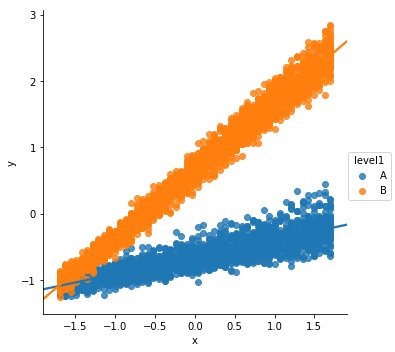

In [5]:
sns.lmplot('x', 'y', hue='level1', data=df);

## Modelling in PyMC3

In [6]:
with pm.Model() as hierarchical_model:
    
    # Group-level parameters
    mus = pm.Normal('mixture_mus', mu=0.5, sd=0.5, shape=2)
    beta_mu = pm.NormalMixture('beta_mu', [0.5, 0.5], mu=mus, sd=0.5)

    # Individual-level betas - using non-centered reparameterisation
    beta = pm.Normal("beta", mu=beta_mu, sd=1, shape=len(df['level2'].unique()))
    
    # Error
    eps = pm.HalfNormal('eps', 1)

    # Estimated y values
    y_est = beta[df['level2'].values] * df['x']
    
    # Likelihood
    y_like = pm.Normal('likelihood', y_est, sd=eps, observed=df['y'])

WARNING (theano.gof.cmodule): ModuleCache.refresh() Found key without dll in cache, deleting it. C:\Users\Toby\AppData\Local\Theano\compiledir_Windows-10-10.0.17134-Intel64_Family_6_Model_78_Stepping_3_GenuineIntel-2.7.14-64\tmpve1ga7\key.pkl
WARNING (theano.gof.compilelock): Overriding existing lock by dead process '14912' (I am process '17564')


In [7]:
with hierarchical_model:
    trace = pm.sample(1000, chains=1, tune=500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [eps, beta, beta_mu, mixture_mus]
100%|█████████████████████████████████████████████████████████████████████████████| 1500/1500 [00:08<00:00, 180.48it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


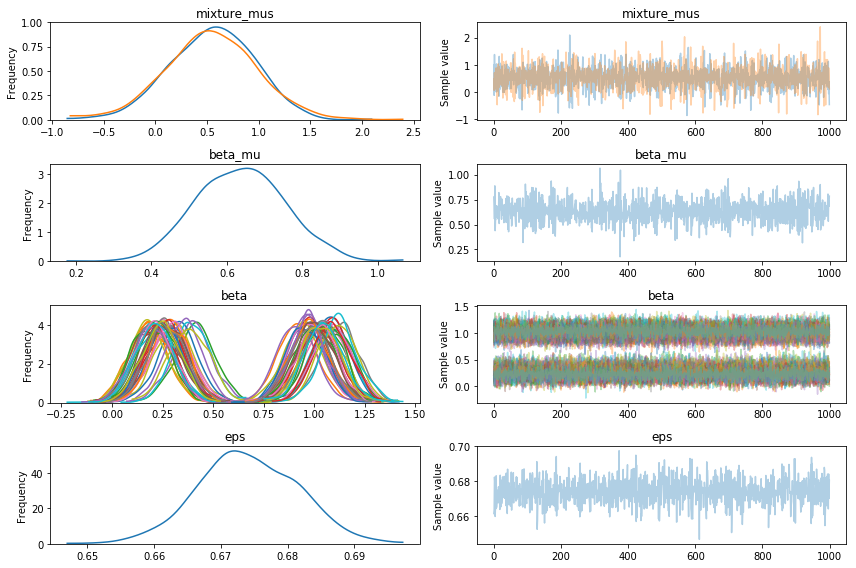

In [8]:
pm.traceplot(trace);
plt.savefig('mixture.png')